# 06_business_insights.ipynb

Proyecto: Análisis del desempeño logístico y satisfacción del cliente en ecommerce (México) <br>
Versión: v1

## Análisis por Negocio

En este apartado se busca conocer mejor cómo se distribuyen las ventas en términos de categorías y vendedores.
El objetivo es identificar patrones de concentración, desempeño y posibles áreas de mejora.

Aunque el dataset no permite analizar recurrencia de clientes (pues cada cliente es único), sí es posible observar qué categorías son más populares y qué vendedores concentran más pedidos o valor total.

Este análisis se apoya en los datasets previamente limpiados y enriquecidos, y busca ofrecer una primera lectura del desempeño comercial desde una perspectiva de negocio.

In [1]:
# Carga de datasets enriquecidos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


path = "https://raw.githubusercontent.com/RaquelGlez/ecommerce_report/refs/heads/main/data/processed/"
orders = pd.read_csv(path + 'orders_enriched.csv')
order_items = pd.read_csv(path + 'order_items_clean.csv')
products = pd.read_csv(path + 'products_clean.csv')
sellers = pd.read_csv(path + 'sellers_clean.csv')


# Vista inicial
print("Shapes:")
print("order_items:", order_items.shape)
print("products:", products.shape)
print("sellers:", sellers.shape)
print("orders (for checks):", orders.shape)


Shapes:
order_items: (8904, 7)
products: (200, 9)
sellers: (100, 4)
orders (for checks): (3000, 16)


En esta sección se cargan los datasets necesarios para el análisis de insights de negocio. Se utiliza el dataset de pedidos enriquecido como base principal y se complementa con la información de productos, vendedores y detalles de los pedidos.

Esta integración permite analizar el comportamiento del negocio desde distintas perspectivas, ventas, productos y vendedores, y sirve como punto de partida para los análisis posteriores del notebook.

En el siguiente paso se inspeccionan las columnas principales de los datasets de pedidos, productos y vendedores, identificando variables relacionadas con precios, costos de envío, características de los productos y ubicación de los sellers, que servirán como base para los análisis posteriores.

La información de ubicación se incorpora como contexto, aunque el foco del análisis se mantiene en métricas comerciales y operativas.

In [2]:
print("order_items columns:", order_items.columns.tolist())
display(order_items.head(3))

print("products columns:", products.columns.tolist())
display(products.head(3))

print("sellers columns:", sellers.columns.tolist())
display(sellers.head(3))

order_items columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,ord_7370c26ead3d3cc6cee4f0548b8d,1,prod_00086,sell_00084,2025-08-18 21:12:27.948040,4469.86,480.12
1,ord_079072dd7970d40a3922a6b0c459,1,prod_00181,sell_00028,2024-12-13 02:52:21.349382,1127.00,149.09
2,ord_2600b1cb6f6a38610007a8c9142c,1,prod_00041,sell_00092,2025-06-16 03:04:55.053859,1977.65,160.03


products columns: ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,prod_00001,electrónica,8,188,2,2278,43,40,30
1,prod_00002,ropa,11,76,3,2968,48,11,13
2,prod_00003,hogar,12,85,1,4795,32,35,15


sellers columns: ['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,sell_00001,49469,Nueva Tailandia,Jalisco
1,sell_00002,10644,Vieja Cuba,Hidalgo
2,sell_00003,28883,Nueva Eritrea,Nayarit


Ahora se calcula el valor total por ítem (item_total) como la suma del precio del producto y el costo de envío, generando una métrica clave que se utilizará más adelante para analizar ingresos, costos y patrones de venta a nivel de pedido, producto y vendedor.

In [3]:
# Asegurar tipos numéricos
order_items['price'] = pd.to_numeric(order_items['price'], errors='coerce')
order_items['freight_value'] = pd.to_numeric(order_items['freight_value'], errors='coerce')

# Calcular item_total (precio + flete)
order_items['item_total'] = order_items['price'].fillna(0) + order_items['freight_value'].fillna(0)

# Revisión rápida
order_items[['order_id','order_item_id','product_id','seller_id','price','freight_value','item_total']].head()


,order_id,order_item_id,product_id,seller_id,price,freight_value,item_total
0,ord_7370c26ead3d3cc6cee4f0548b8d,1,prod_00086,sell_00084,4469.86,480.12,4949.98
1,ord_079072dd7970d40a3922a6b0c459,1,prod_00181,sell_00028,1127.00,149.09,1276.09
2,ord_2600b1cb6f6a38610007a8c9142c,1,prod_00041,sell_00092,1977.65,160.03,2137.68
3,ord_aaa7c4626ea7ea636e5bba7afebd,1,prod_00027,sell_00080,914.42,75.57,989.99
4,ord_0ca0641b834ceb0a46f85637e125,1,prod_00038,sell_00053,3934.04,469.71,4403.75


Se realiza un merge con el dataset de productos para añadir la categoría y atributos del producto a cada ítem de pedido. El resultado es un dataset enriquecido sin registros faltantes en la categoría de producto.

In [4]:
# Seleccionar columnas que nos interesan de products
prod_cols = ['product_id', 'product_category_name', 'product_name_lenght',
             'product_description_lenght', 'product_photos_qty', 'product_weight_g']

products_small = products[prod_cols].drop_duplicates(subset=['product_id'])

# Merge (left join para conservar todos los items)
order_items = order_items.merge(products_small, on='product_id', how='left')

# Verificar cantidad de product_id sin match
missing_prod = order_items['product_category_name'].isna().sum()
print(f"Faltantes de categoría de producto: {missing_prod} filas ({missing_prod/len(order_items):.2%})")


Faltantes de categoría de producto: 0 filas (0.00%)


En el siguiente paso se realiza la unión con el dataset de sellers para añadir información de ubicación del vendedor (ciudad y estado), verificando que no existan registros sin correspondencia, lo que garantiza la consistencia del dataset enriquecido.

In [5]:
# Seleccionar columnas relevantes de sellers
seller_cols = ['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']
sellers_small = sellers[seller_cols].drop_duplicates(subset=['seller_id'])

# Merge con sellers (left join)
order_items = order_items.merge(sellers_small, on='seller_id', how='left')

# Verificar cuantos sellers faltan
missing_sellers = order_items['seller_city'].isna().sum()
print(f"Faltantes de vendedor (sin info): {missing_sellers} filas ({missing_sellers/len(order_items):.2%})")


Faltantes de vendedor (sin info): 0 filas (0.00%)


Se verifica si hay duplicados por `order_id`, `order_item_id`

In [6]:
dup_count = order_items.duplicated(subset=['order_id','order_item_id']).sum()
print("Duplicados (order_id + order_item_id):", dup_count)

Duplicados (order_id + order_item_id): 0


Como paso de control, se valida que la suma del valor de los ítems (item_total) por pedido coincida con el monto total registrado en el dataset de órdenes (order_total_value).



In [7]:
# Sumar item_total por order_id
items_sum = order_items.groupby('order_id')['item_total'].sum().reset_index().rename(columns={'item_total':'items_sum_total'})

# Unir con orders para comparar
cmp = orders[['order_id','order_total_value']].merge(items_sum, on='order_id', how='left')

# Calcular diferencia y resumen
cmp['diff'] = cmp['order_total_value'] - cmp['items_sum_total']
print("Diferencias resumen:")
display(cmp['diff'].describe().round(2))

# ¿Cuántos pedidos no coinciden (diff no nulo y abs > pequeño epsilon)?
epsilon = 1e-6
mismatch = cmp[cmp['diff'].abs() > epsilon].shape[0]
print(f"Pedidos con diferencia entre order_total_value y suma de items: {mismatch} / {len(cmp)}")

Diferencias resumen:


,diff
count,3000.0
mean,0.0
std,0.0
min,-0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


Pedidos con diferencia entre order_total_value y suma de items: 0 / 3000


Los resultados muestran que no existen diferencias entre ambos cálculos: la diferencia promedio es cero y no se detectan pedidos con discrepancias.
Esto confirma que la información de precios y fletes es consistente entre los datasets y que las uniones realizadas no alteraron los montos de los pedidos.

Ya que no se detectaron diferencias para order_total_value, se pueden preparar agregados útiles (para Business Insights)

### Resumen por categoría
En este paso se incorpora la calificación del cliente (review_score) al nivel de cada ítem del pedido. Para ello, se selecciona la información relevante de las reseñas desde el dataset de pedidos y se realiza un merge con order_items.

In [8]:
# Seleccionar solo las columnas necesarias
orders_reviews = orders[['order_id', 'review_score']]

# Merge: heredar review_score al nivel de item
order_items_with_reviews = order_items.merge(
    orders_reviews,
    on='order_id',
    how='left'
)

order_items_with_reviews.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,item_total,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,seller_zip_code_prefix,seller_city,seller_state,review_score
0,ord_7370c26ead3d3cc6cee4f0548b8d,1,prod_00086,sell_00084,2025-08-18 21:12:27.948040,4469.86,480.12,4949.98,comida,14,129,2,4954,62527,San Gustavo los bajos,Sinaloa,3
1,ord_079072dd7970d40a3922a6b0c459,1,prod_00181,sell_00028,2024-12-13 02:52:21.349382,1127.00,149.09,1276.09,deportes,8,94,1,1129,33273,San Miriam los altos,Jalisco,4
2,ord_2600b1cb6f6a38610007a8c9142c,1,prod_00041,sell_00092,2025-06-16 03:04:55.053859,1977.65,160.03,2137.68,mascotas,15,198,5,1627,31987,Vieja El Salvador,Morelos,4
3,ord_aaa7c4626ea7ea636e5bba7afebd,1,prod_00027,sell_00080,2025-04-28 01:55:37.919760,914.42,75.57,989.99,salud,8,76,2,4175,62856,Vieja Saint Kitts y Nevis,Baja California Sur,3
4,ord_0ca0641b834ceb0a46f85637e125,1,prod_00038,sell_00053,2025-06-22 18:52:40.013157,3934.04,469.71,4403.75,juguetes,13,89,1,4648,91030,Nueva Afganistán,Oaxaca,3


In [9]:
order_items = order_items_with_reviews.copy()

A continuación, se construye un resumen a nivel de categoría de producto, agregando métricas clave como el número de ítems vendidos, el número de pedidos únicos, los ingresos totales, el precio promedio por ítem y la calificación promedio de los clientes.

In [10]:
category_summary = (
    order_items
    .groupby('product_category_name')
    .agg(
        num_items = ('order_item_id','count'),
        num_orders = ('order_id', lambda x: x.nunique()),
        total_revenue = ('item_total','sum'),
        avg_item_price = ('price','mean'),
        avg_review = ('order_id', lambda x: np.nan )
    )
    .sort_values(by='num_items', ascending=False)
)

# Unir review_score por order_id en order_items
if 'review_score' in order_items.columns:
    category_summary['avg_review'] = order_items.groupby('product_category_name')['review_score'].mean()

display(category_summary.head(10))


,num_items,num_orders,total_revenue,avg_item_price,avg_review
product_category_name,,,,,
herramientas,1370,1139,4015672.79,2541.462898,3.818978
deportes,1097,933,3207419.21,2542.987010,3.814950
mascotas,1015,893,2935367.66,2508.303241,3.824631
hogar,912,805,2634103.32,2519.604134,3.745614
salud,897,793,2701311.76,2618.051382,3.885173
electrónica,836,741,2475222.70,2576.854725,3.801435
ropa,823,739,2427762.70,2569.722515,3.769137
comida,707,649,2072999.07,2550.809420,3.851485
juguetes,692,640,1989410.52,2505.987355,3.812139


Este resumen permite identificar qué categorías concentran mayor volumen de ventas y facturación, así como observar si existen diferencias relevantes en la percepción del cliente entre categorías. En los resultados se aprecia que categorías como herramientas, deportes y mascotas lideran tanto en número de ítems como en ingresos totales, lo que sugiere una alta demanda y peso comercial dentro del catálogo.

Las calificaciones promedio se mantienen relativamente homogéneas entre categorías, con valores cercanos a 3.8–3.9, lo que indica que, en general, la satisfacción del cliente no presenta contrastes marcados entre tipos de producto, al menos dentro de este dataset sintético.

### Resumen por vendedor
Ahora se construye un resumen a nivel vendedor para entender cómo se distribuyen los pedidos y los ingresos entre los distintos sellers de la plataforma. A partir del dataset de order_items, se calculan métricas básicas como número de ítems vendidos, número de pedidos atendidos, ingreso total generado y precio promedio por ítem.

In [11]:
seller_summary = (
    order_items
    .groupby('seller_id')
    .agg(
        num_items = ('order_item_id','count'),
        num_orders = ('order_id', lambda x: x.nunique()),
        total_revenue = ('item_total','sum'),
        avg_item_price = ('price','mean')
    )
    .sort_values(by='num_orders', ascending=False)
)

# Añadir info de localización de seller
seller_summary = seller_summary.reset_index().merge(sellers_small, on='seller_id', how='left')
display(seller_summary.head(10))


,seller_id,num_items,num_orders,total_revenue,avg_item_price,seller_zip_code_prefix,seller_city,seller_state
0,sell_00040,107,105,305997.47,2482.108505,96751,San Alicia los altos,Tabasco
1,sell_00087,105,104,301547.27,2494.435905,15199,Nueva Omán,Oaxaca
2,sell_00053,106,103,300566.06,2468.882170,91030,Nueva Afganistán,Oaxaca
3,sell_00009,102,102,319880.90,2740.537745,20019,Nueva Bulgaria,Baja California Sur
4,sell_00080,102,102,310870.50,2674.000490,62856,Vieja Saint Kitts y Nevis,Baja California Sur
5,sell_00031,101,101,298564.94,2569.949208,17776,Nueva Nauru,Sonora
6,sell_00085,103,101,343357.12,2885.613495,70675,San Pedro los altos,Guerrero
7,sell_00050,103,101,308534.36,2584.611359,63630,San Georgina de la Montaña,Querétaro
8,sell_00086,101,100,305159.44,2635.382673,5677,Vieja Mónaco,Sinaloa
9,sell_00068,100,99,295780.33,2576.143300,47102,San Alberto de la Montaña,Sonora


En conjunto, los resultados muestran que, incluso entre los vendedores con mayor volumen de pedidos, las diferencias en número de órdenes y en ingresos totales no son extremadamente marcadas. Los vendedores con más actividad concentran alrededor de 100 pedidos y un volumen de ingresos relativamente similar, lo que sugiere una distribución bastante equilibrada de la demanda entre los sellers más activos.

También se observa que el precio promedio por ítem se mantiene en rangos cercanos entre vendedores, sin outliers evidentes, lo que refuerza la idea de que el comportamiento del marketplace es homogéneo en este nivel. La incorporación de la ubicación permite identificar la diversidad geográfica de los vendedores, aunque en este análisis el foco principal se mantiene en las métricas operativas y comerciales más que en la comparación regional.

Este resumen sirve como una primera aproximación para identificar vendedores relevantes y sienta las bases para análisis posteriores más específicos, como desempeño por categoría, concentración de ingresos o comparaciones más detalladas entre sellers.

## Business Insights - Análisis de categorías, vendedores y patrones de venta

## Análisis por categoría de producto

En esta sección se revisa la información de ventas con el objetivo de entender mejor qué está pasando dentro del dataset. El análisis se enfoca en ver qué categorías de productos aparecen con mayor frecuencia, qué vendedores tienen más participación y cómo se reparte el valor de las ventas entre ambos.

Para esto se utiliza información combinada de pedidos, productos y vendedores, considerando aspectos como la categoría del producto, la ubicación del vendedor y el valor total de cada ítem. A partir de estos datos se generan visualizaciones sencillas que ayudan a identificar qué categorías y vendedores destacan frente al resto.

El propósito de esta sección es ofrecer una vista clara y fácil de interpretar sobre el comportamiento general de los productos y vendedores, funcionando como un primer acercamiento que puede servir de base para análisis más profundos en el futuro.


Aquí se analizan:
- Las categorías más vendidas en volumen  
- Las que generan mayor ingreso  
- El precio promedio por ítem  

Este tipo de análisis ayuda a entender qué productos destacan más dentro del catálogo disponible.


In [12]:
category_summary = category_summary.reset_index()
top_categories_qty = (
    category_summary
    .sort_values("num_items", ascending=False)
    .head(10)
)

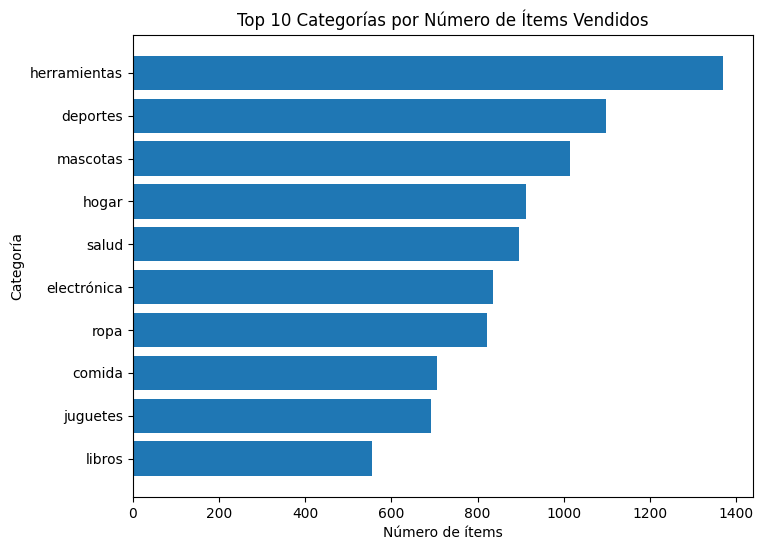

In [13]:
top_categories_qty = (
    category_summary
    .sort_values("num_items", ascending=False)
    .head(10)
)

plt.figure(figsize=(8,6))
plt.barh(top_categories_qty['product_category_name'], top_categories_qty['num_items'])
plt.title("Top 10 Categorías por Número de Ítems Vendidos")
plt.xlabel("Número de ítems")
plt.ylabel("Categoría")
plt.gca().invert_yaxis()
plt.show()


Esta visualización muestra las categorías de productos con mayor volumen de ítems vendidos. Se observa que herramientas, deportes y mascotas concentran la mayor cantidad de ventas en términos de unidades, lo que sugiere una alta demanda y rotación en estas categorías dentro del dataset.

En contraste, categorías como libros y juguetes presentan un menor volumen relativo, lo cual no implica necesariamente un bajo desempeño, sino que pueden corresponder a productos con menor frecuencia de compra o ciclos de venta distintos. En conjunto, este gráfico permite identificar de forma rápida qué tipos de productos dominan el movimiento de pedidos y sirve como punto de partida para analizar ingresos, precios promedio o participación de vendedores por categoría.

### Categorías con mayor valor total generado

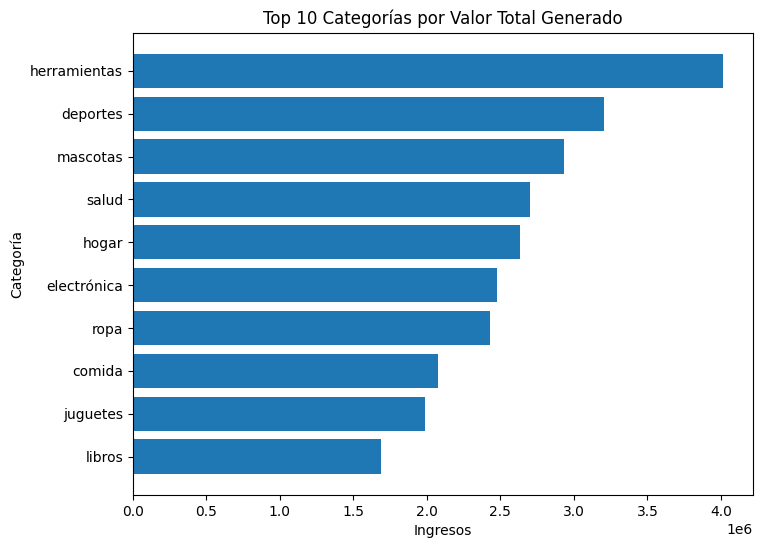

In [14]:
top_categories_value = (
    category_summary
    .sort_values("total_revenue", ascending=False)
    .head(10)
)

plt.figure(figsize=(8,6))
plt.barh(top_categories_value['product_category_name'], top_categories_value['total_revenue'])
plt.title("Top 10 Categorías por Valor Total Generado")
plt.xlabel("Ingresos")
plt.ylabel("Categoría")
plt.gca().invert_yaxis()
plt.show()


Este gráfico muestra las categorías que generan mayor valor total de ventas, considerando la suma del ingreso de todos los ítems vendidos. Se observa que herramientas y deportes no solo lideran en volumen de unidades, sino también en valor económico, lo que indica que su alta demanda se combina con precios relativamente elevados.

Otras categorías como salud, hogar y electrónica mantienen una participación relevante en ingresos, aun cuando no siempre encabezan el ranking por número de ítems. Esto sugiere diferencias en el precio promedio y en el tipo de productos vendidos. En conjunto, esta visualización complementa el análisis de volumen y permite entender mejor qué categorías son las que más aportan al valor total generado dentro del dataset.

### Precio promedio por categoría

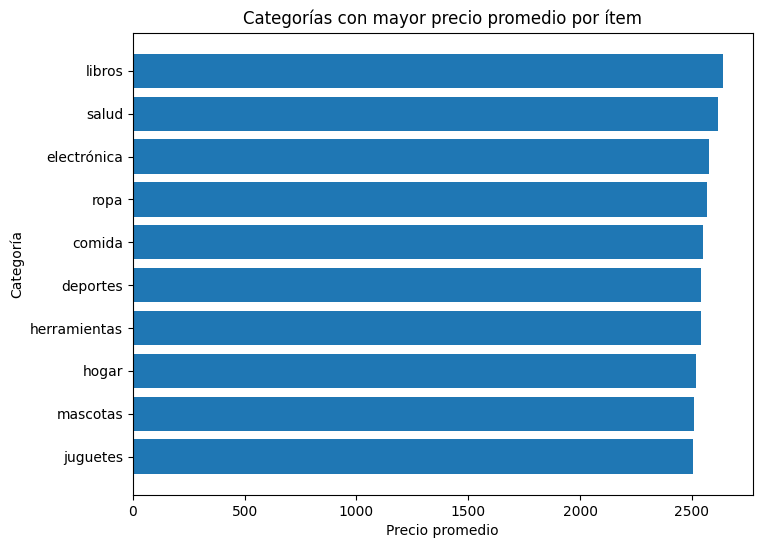

In [15]:
top_avg_price = (
    category_summary
    .sort_values("avg_item_price", ascending=False)
    .head(10)
)

plt.figure(figsize=(8,6))
plt.barh(top_avg_price['product_category_name'], top_avg_price['avg_item_price'])
plt.title("Categorías con mayor precio promedio por ítem")
plt.xlabel("Precio promedio")
plt.ylabel("Categoría")
plt.gca().invert_yaxis()
plt.show()


En este gráfico se comparan las categorías con mayor precio promedio por ítem, lo que permite entender qué tipos de productos tienden a ser más costosos en el dataset. Se observa que categorías como libros, salud y electrónica se ubican entre las de mayor precio promedio, lo que sugiere la presencia de productos de mayor valor unitario en comparación con otras categorías.

A diferencia de los gráficos de volumen o valor total, esta visualización pone el foco en el precio individual de los artículos. Esto ayuda a contextualizar por qué algunas categorías generan altos ingresos con menos unidades vendidas, mientras que otras dependen más del volumen para aportar al total de ventas.

## Análisis por vendedor
En esta sección se observa cómo se distribuye la actividad entre los distintos vendedores del dataset. Se analizan aspectos como la cantidad de pedidos en los que participan, el número de productos vendidos y el ingreso total que generan.

El objetivo es tener una referencia general sobre qué tan concentrada está la operación en ciertos vendedores y cómo varía su contribución dentro del conjunto de datos, sin entrar aún en evaluaciones de desempeño individual.


### Vendedores con más pedidos

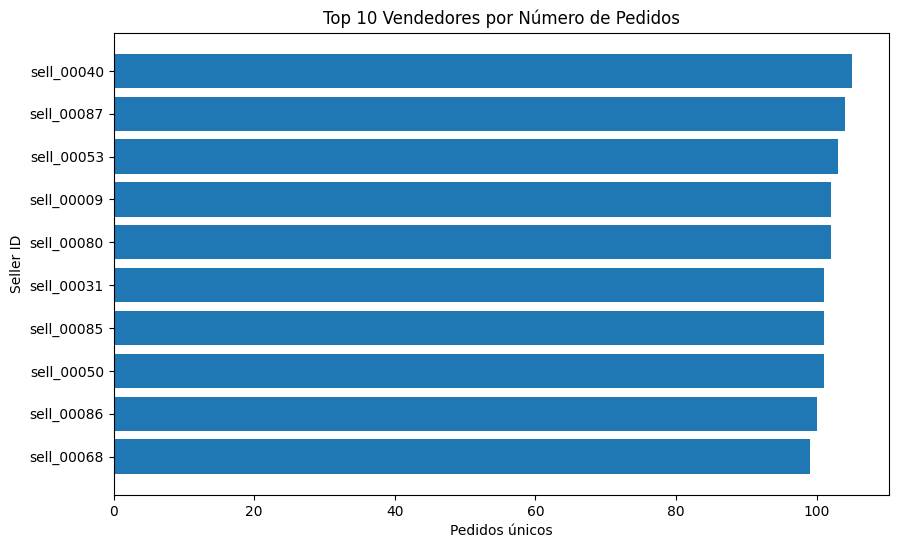

In [16]:
top_sellers_orders = (
    seller_summary
    .sort_values("num_orders", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
plt.barh(top_sellers_orders['seller_id'], top_sellers_orders['num_orders'])
plt.title("Top 10 Vendedores por Número de Pedidos")
plt.xlabel("Pedidos únicos")
plt.ylabel("Seller ID")
plt.gca().invert_yaxis()
plt.show()


En esta gráfica se presentan los 10 vendedores con mayor número de pedidos únicos. Se observa que todos ellos manejan volúmenes muy cercanos entre sí, lo que indica que la actividad está relativamente bien distribuida entre los vendedores más activos, sin una concentración excesiva en un solo participante.

Este panorama permite entender que la actividad está repartida entre distintos vendedores relevantes, y sirve como punto de partida para analizar si este nivel de participación también se refleja en los ingresos generados o en otras diferencias de desempeño.

### Vendedores con más ítems vendidos

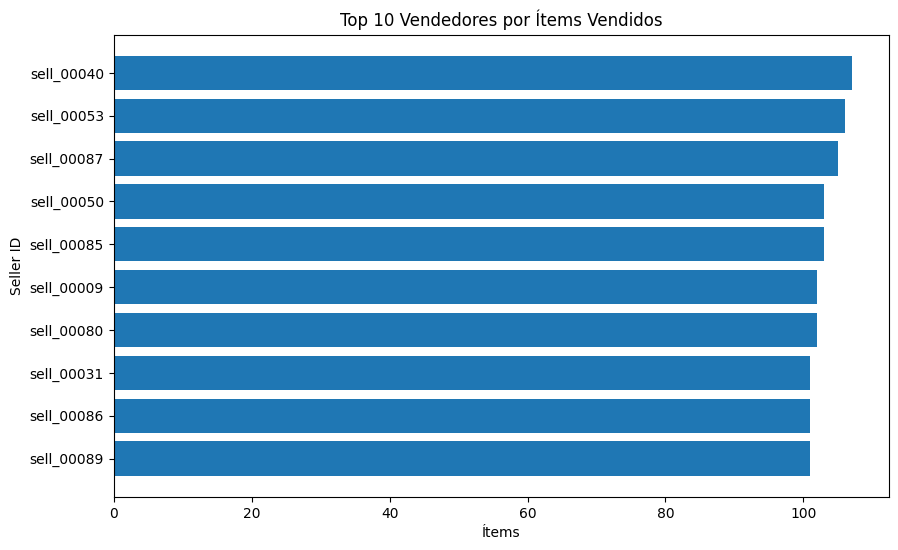

In [17]:
top_sellers_items = (
    seller_summary
    .sort_values("num_items", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
plt.barh(top_sellers_items['seller_id'], top_sellers_items['num_items'])
plt.title("Top 10 Vendedores por Ítems Vendidos")
plt.xlabel("Ítems")
plt.ylabel("Seller ID")
plt.gca().invert_yaxis()
plt.show()


Esta visualización muestra a los 10 vendedores con mayor número de ítems vendidos. Al igual que en el análisis por pedidos, se observa que las diferencias entre los vendedores son relativamente pequeñas, lo que indica un nivel de actividad bastante parejo entre los más activos.

Esto sugiere que el volumen de productos vendidos está distribuido entre varios vendedores, sin una concentración extrema en uno solo. Este resultado ayuda a entender que el desempeño destacado no depende únicamente de un vendedor dominante, sino de un grupo amplio que aporta de forma consistente al volumen total de ventas.

### Vendedores que generan más ingresos

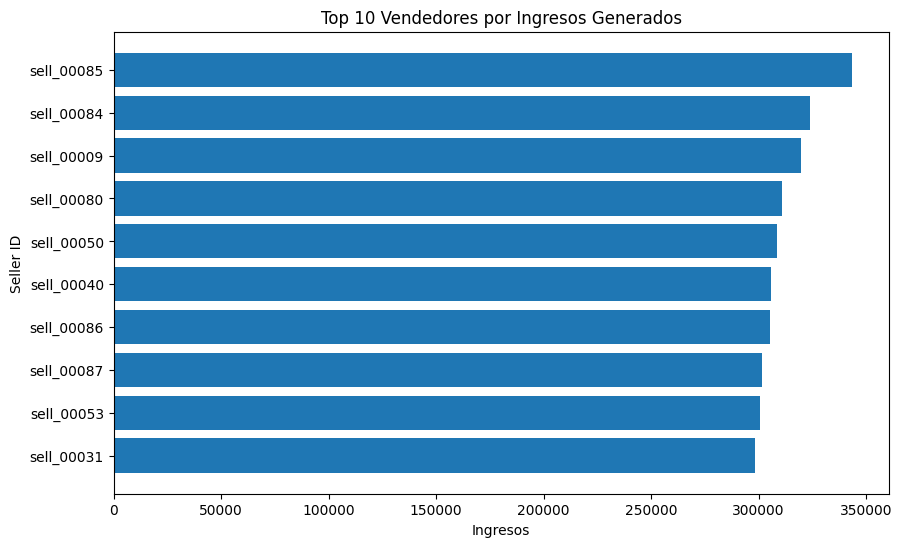

In [18]:
top_sellers_revenue = (
    seller_summary
    .sort_values("total_revenue", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
plt.barh(top_sellers_revenue['seller_id'], top_sellers_revenue['total_revenue'])
plt.title("Top 10 Vendedores por Ingresos Generados")
plt.xlabel("Ingresos")
plt.ylabel("Seller ID")
plt.gca().invert_yaxis()
plt.show()


En esta visualización se muestran los vendedores que generan mayores ingresos dentro del dataset. A diferencia de los gráficos anteriores, aquí se aprecia una ligera mayor separación entre los primeros lugares, lo que indica que, aunque varios vendedores tienen niveles de actividad similares, no todos convierten ese volumen en el mismo nivel de ingresos.

Esto sugiere que algunos vendedores logran un mejor desempeño económico, ya sea por vender productos de mayor precio promedio o por una combinación de volumen y valor. Este análisis ayuda a distinguir entre vendedores activos y aquellos que, además, tienen un impacto más relevante en los ingresos totales.

## Cruce: Categorías más vendidas vs Vendedores principales
En esta sección se explora la relación entre categorías de producto y vendedores, con el objetivo de entender cómo se distribuye la actividad de venta entre ambos. Este cruce permite observar si los vendedores tienden a concentrarse en ciertas categorías o si, por el contrario, mantienen una oferta más diversificada dentro del catálogo.

El análisis ayuda a contextualizar el peso de las categorías más vendidas y a identificar posibles dependencias o especializaciones por parte de los vendedores.


### Tabla dinámica: vendedores × categoría

In [19]:
pivot_seller_cat = pd.pivot_table(
    order_items,
    index='seller_id',
    columns='product_category_name',
    values='order_item_id',
    aggfunc='count',
    fill_value=0
)

pivot_seller_cat.head()


product_category_name,comida,deportes,electrónica,herramientas,hogar,juguetes,libros,mascotas,ropa,salud
seller_id,,,,,,,,,,
sell_00001,6,13,9,16,8,3,6,14,3,9
sell_00002,8,6,7,13,12,7,6,8,9,5
sell_00003,9,9,9,16,10,8,5,11,9,7
sell_00004,6,14,6,12,7,7,11,13,3,11
sell_00005,8,10,9,9,10,7,7,11,5,16


La tabla muestra, para cada vendedor, el número de ítems vendidos en cada categoría de producto. A partir de esta vista es posible identificar diferencias claras en el comportamiento de los vendedores: algunos presentan una distribución relativamente equilibrada entre varias categorías, mientras que otros concentran una mayor parte de sus ventas en pocas categorías específicas.

Este tipo de resumen facilita detectar patrones de especialización y posibles concentraciones de ventas, lo cual resulta útil para entender mejor cómo se estructura la oferta dentro del marketplace y qué categorías tienen mayor peso en la actividad de los vendedores más representativos.

Para facilitar la lectura, el mapa de calor se limita a los vendedores con mayor actividad.

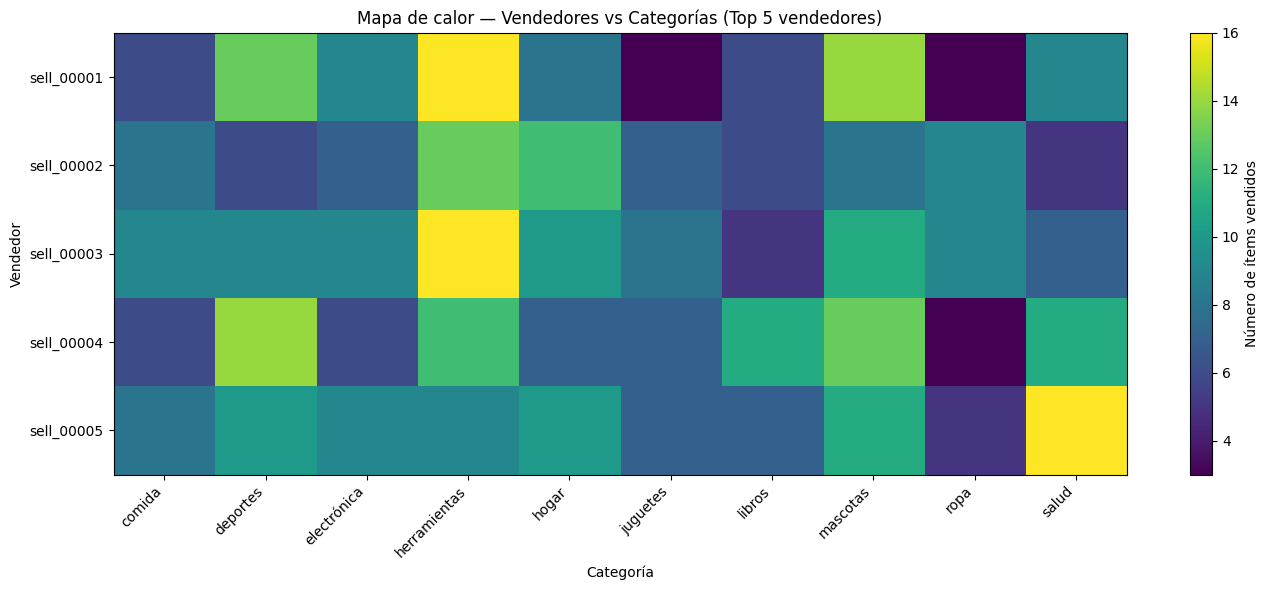

In [20]:
top5 = pivot_seller_cat.head(5)

plt.figure(figsize=(14,6))
plt.imshow(top5, aspect='auto')

plt.title("Mapa de calor — Vendedores vs Categorías (Top 5 vendedores)")
plt.xlabel("Categoría")
plt.ylabel("Vendedor")

# Etiquetas del eje X (categorías)
plt.xticks(
    ticks=range(len(top5.columns)),
    labels=top5.columns,
    rotation=45,
    ha='right'
)

# Etiquetas del eje Y (seller_id)
plt.yticks(
    ticks=range(len(top5.index)),
    labels=top5.index
)

plt.colorbar(label="Número de ítems vendidos")
plt.tight_layout()
plt.show()

El mapa de calor permite visualizar de forma más intuitiva cómo se distribuyen los ítems vendidos por los principales vendedores a través de las distintas categorías. Las variaciones de color facilitan identificar rápidamente en qué categorías cada vendedor concentra mayor actividad y dónde su participación es menor.

Se observa que, aunque algunos vendedores muestran una presencia relativamente balanceada, en varios casos destacan picos claros en categorías específicas, lo que sugiere cierto grado de especialización. Al mismo tiempo, el mapa evidencia que no todos los vendedores lideran en las mismas categorías, lo cual apunta a una distribución diversa de la oferta y a distintos enfoques dentro del marketplace.

Esta visualización complementa la tabla anterior al resaltar patrones y contrastes que pueden pasar desapercibidos en un formato puramente numérico.

### Conclusiones

El análisis realizado en este notebook permite obtener una visión general de cómo se distribuyen las ventas dentro del dataset, tanto desde la perspectiva de las categorías de producto como de los vendedores. A partir de la integración de la información de pedidos, productos y vendedores, fue posible identificar patrones relevantes de volumen, valor e ingresos.

En el análisis por categoría, se observa que algunas categorías destacan de forma consistente en distintos indicadores. Categorías como herramientas, deportes y mascotas concentran una gran parte del volumen de ítems vendidos y también figuran entre las que generan mayor valor total. Esto sugiere que combinan una alta demanda con precios que, en conjunto, representan un peso importante dentro de las ventas totales.

En cuanto a la satisfacción del cliente, las calificaciones promedio por categoría se mantienen relativamente homogéneas, sin diferencias extremas entre tipos de producto. Esto indica que, al menos en este dataset, la experiencia del cliente es bastante consistente entre categorías, independientemente del volumen o del valor generado.

Desde la perspectiva de los vendedores, los resultados muestran una distribución bastante equilibrada entre los sellers más activos. Los vendedores con mayor número de pedidos y de ítems vendidos presentan volúmenes muy similares, lo que sugiere que no existe una concentración excesiva de la actividad en un solo participante. Sin embargo, al analizar los ingresos generados, se observan ligeras diferencias: algunos vendedores logran convertir un nivel de actividad similar en mayores ingresos, lo que puede estar relacionado con el tipo de productos que venden o con su precio promedio.

El cruce entre categorías y vendedores, tanto a través de la tabla dinámica como del mapa de calor, aporta una capa adicional de contexto. Este análisis muestra que algunos vendedores mantienen una oferta relativamente diversificada entre varias categorías, mientras que otros concentran una parte importante de sus ventas en categorías específicas. Este comportamiento sugiere distintos perfiles de vendedor dentro del marketplace, desde sellers generalistas hasta otros más especializados.

En conjunto, este notebook ofrece una visión clara y estructurada de cómo se distribuyen las ventas entre categorías y vendedores dentro del dataset.

Los resultados permiten comprender el comportamiento general del catálogo y de los participantes del marketplace, cerrando el análisis exploratorio con una perspectiva integrada sobre volumen, valor y participación.

En conjunto, este notebook ofrece una visión exploratoria del desempeño comercial del marketplace, permitiendo identificar categorías con mayor peso en volumen e ingresos, así como patrones generales en la actividad de los vendedores.

Los resultados muestran un comportamiento relativamente homogéneo, consistente con la naturaleza sintética del dataset, y sirven como un primer acercamiento para entender cómo se distribuye la actividad de ventas dentro de la plataforma.

Este análisis cierra el estudio desde una perspectiva de negocio y sienta una base clara para futuros ejercicios con datos reales, donde estos mismos enfoques pueden derivar en insights más accionables.

### Exportación de datasets enriquecidos y resúmenes

En la ejecución original del proyecto, este notebook generó una versión enriquecida del dataset de ítems de pedidos, así como tablas de resumen a nivel de categoría de producto y de vendedor.  
Estos archivos fueron almacenados como CSV para facilitar su reutilización en análisis posteriores y la exploración de patrones agregados.

En la versión actual del proyecto (orientada a portafolio), estos datasets ya se encuentran versionados dentro del repositorio de GitHub en la carpeta `data/processed`.  
Por este motivo, los bloques de guardado de archivos se conservan únicamente como referencia del proceso seguido y no se ejecutan nuevamente al correr el notebook.


In [21]:
#out_path = path + "order_items_enriched.csv"
#order_items.to_csv(out_path, index=False)

#category_summary.to_csv(path + "category_summary_from_items.csv")
#seller_summary.to_csv(path + "seller_summary_from_items.csv")